In [22]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import ylabel

/tmp/ipykernel_2317215/3091791864.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load('output.pt')


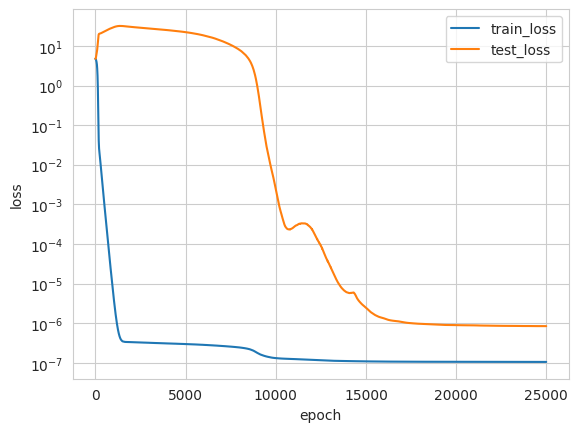

In [23]:
results = torch.load('output.pt')
plt.plot(results['train_losses'])
plt.plot(results['test_losses'])

plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss'])

In [24]:
results.keys()

dict_keys(['model', 'config', 'checkpoints', 'checkpoint_epochs', 'test_losses', 'train_losses', 'train_data', 'test_data'])

/tmp/ipykernel_2317215/1060897627.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load('output_plus_and_minus.pt')


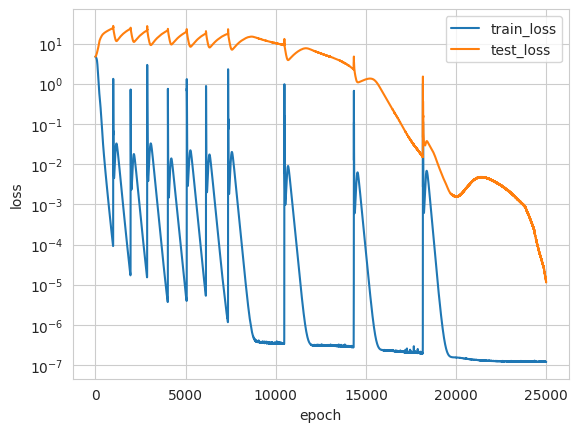

In [25]:
results = torch.load('output_plus_and_minus.pt')
plt.plot(results['train_losses'])
plt.plot(results['test_losses'])

plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss',])


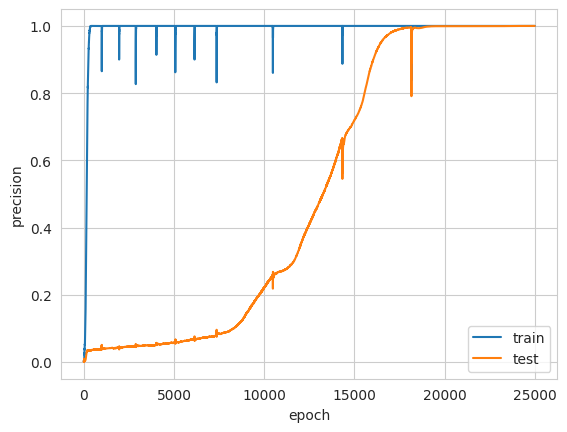

In [26]:
results.keys()
plt.plot(results['train_precision_scores'])
plt.plot(results['test_precision_scores'])
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'])


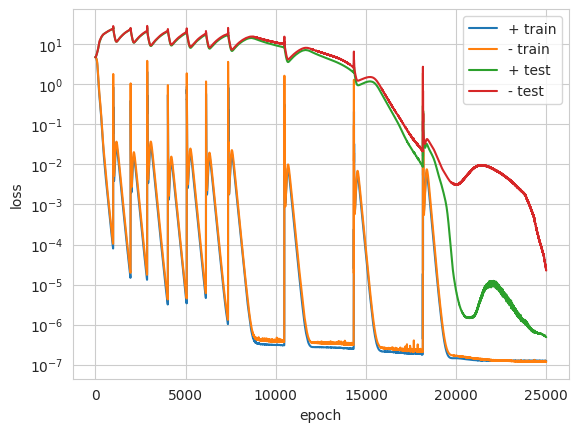

In [27]:
for operation in results['operations_losses']:
    plt.plot(operation['train_losses'])
for operation in results['operations_losses']:
    plt.plot(operation['test_losses'])
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['+ train', '- train', '+ test', '- test'])


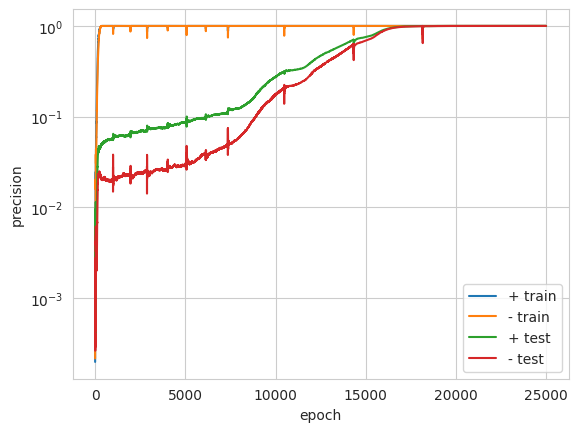

In [28]:
for operation in results['operations_losses']:
    plt.plot(operation['train_precisions'])
for operation in results['operations_losses']:
    plt.plot(operation['test_precisions'])
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['+ train', '- train', '+ test', '- test'])
plt.yscale('log')

In [29]:
from transformer_lens import HookedTransformer, HookedTransformerConfig, HookedEncoderDecoder

In [30]:
model = HookedTransformer(results['config'])
model.load_state_dict(results['model'])

<All keys matched successfully>

## Show model works

In [31]:
# (1 + 15) % 113
model(torch.tensor([1, 114, 15, 113]))[0,3].argmax().item()

16

In [32]:
# (1 - 15) % 113
model(torch.tensor([1, 115, 15, 113]))[0, 3].argmax().item()

99

## Run model on full dataset to look at activations/attention patterns

In [57]:
full_dataset = torch.concat([results['test_data'], results['train_data']], dim=0)
full_dataset.shape

torch.Size([25538, 4])

In [58]:
output, cache = model.run_with_cache(full_dataset)

In [35]:
av_attention = cache["pattern", 0].mean(dim=0).detach().cpu()

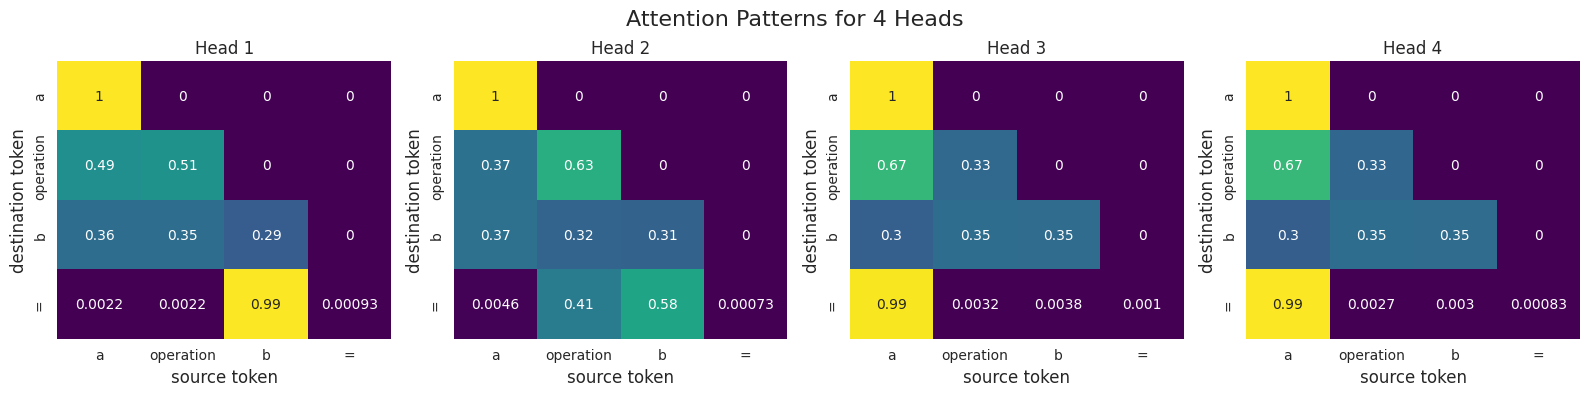

In [36]:
labels = ['a', 'operation', 'b', '=']
# Create a figure to hold the 4 attention head plots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        av_attention[i],
        annot=True,            # Annotate each cell with its value
        xticklabels=labels,    # Set x-axis labels
        yticklabels=labels,    # Set y-axis labels
        cmap="viridis",        # Use a color map
        cbar=False,            # Disable color bar to reduce clutter
        ax=ax,                  # Plot on the current axis
    )
    ax.set_title(f'Head {i + 1}', fontsize=12)
    ax.set_ylabel('destination token', fontsize=12)
    ax.set_xlabel('source token', fontsize=12)

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

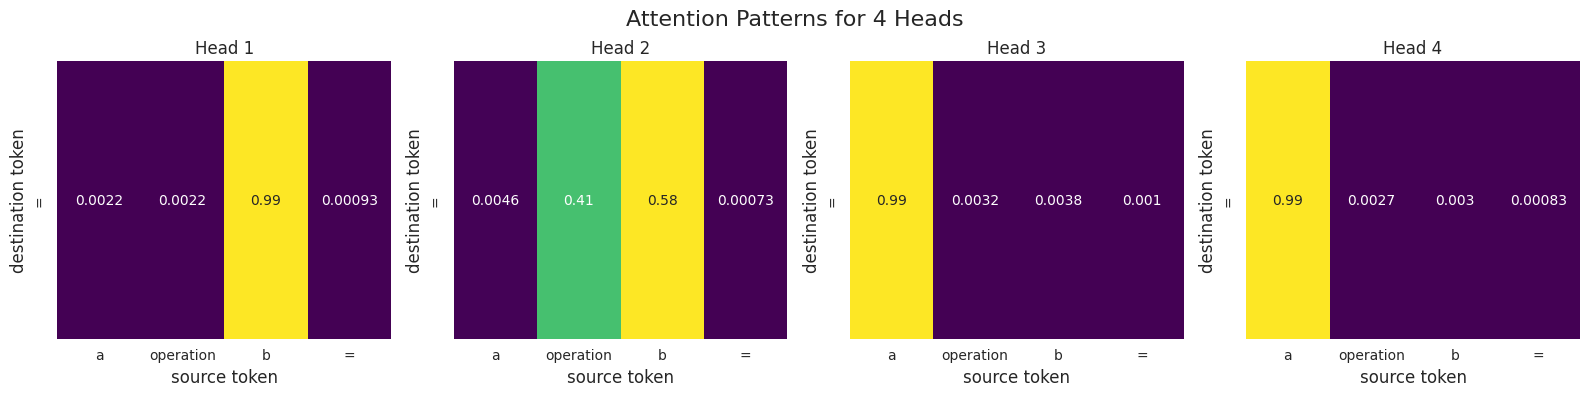

In [37]:
# plot just attn where = is the destination (all we care about)
labels = ['a', 'operation', 'b', '=']
# Create a figure to hold the 4 attention head plots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        av_attention[i, -1:],
        annot=True,            # Annotate each cell with its value
        xticklabels=labels,    # Set x-axis labels
        yticklabels=["="],    # Set y-axis labels
        cmap="viridis",        # Use a color map
        cbar=False,            # Disable color bar to reduce clutter
        ax=ax                  # Plot on the current axis
    )
    ax.set_title(f'Head {i + 1}', fontsize=12)
    ax.set_ylabel('destination token', fontsize=12)
    ax.set_xlabel('source token', fontsize=12)

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

### Attention patterns for +

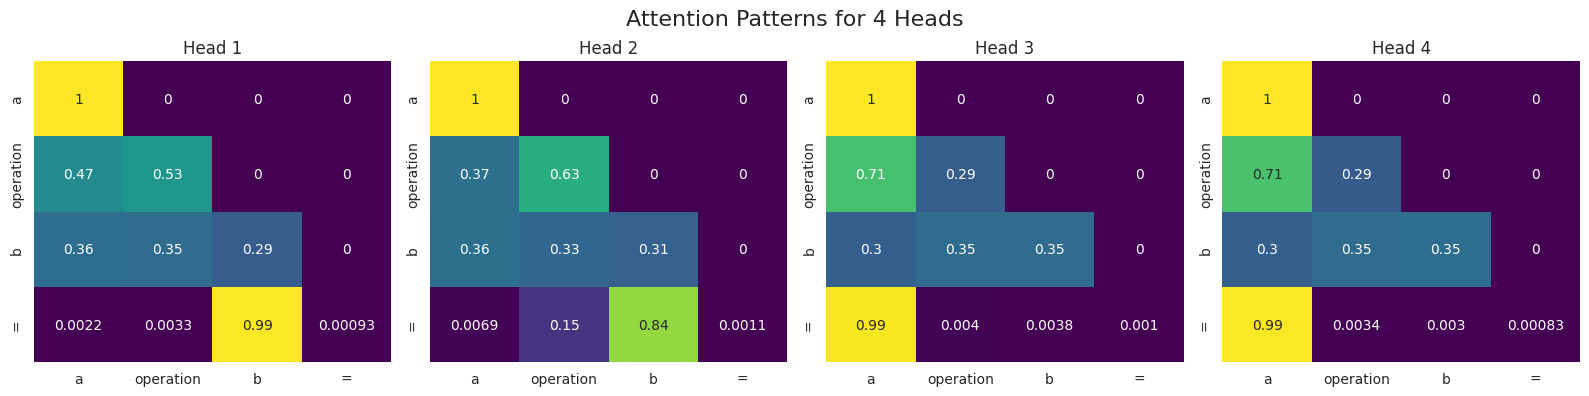

In [62]:
output_plus, cache_plus = model.run_with_cache(full_dataset[0::2])
av_attention = cache_plus["pattern", 0].mean(dim=0).detach().cpu()
labels = ['a', 'operation', 'b', '=']
# Create a figure to hold the 4 attention head plots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        av_attention[i],
        annot=True,  # Annotate each cell with its value
        xticklabels=labels,  # Set x-axis labels
        yticklabels=labels,  # Set y-axis labels
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'Head {i + 1}', fontsize=12)

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

### Attention patterns for -

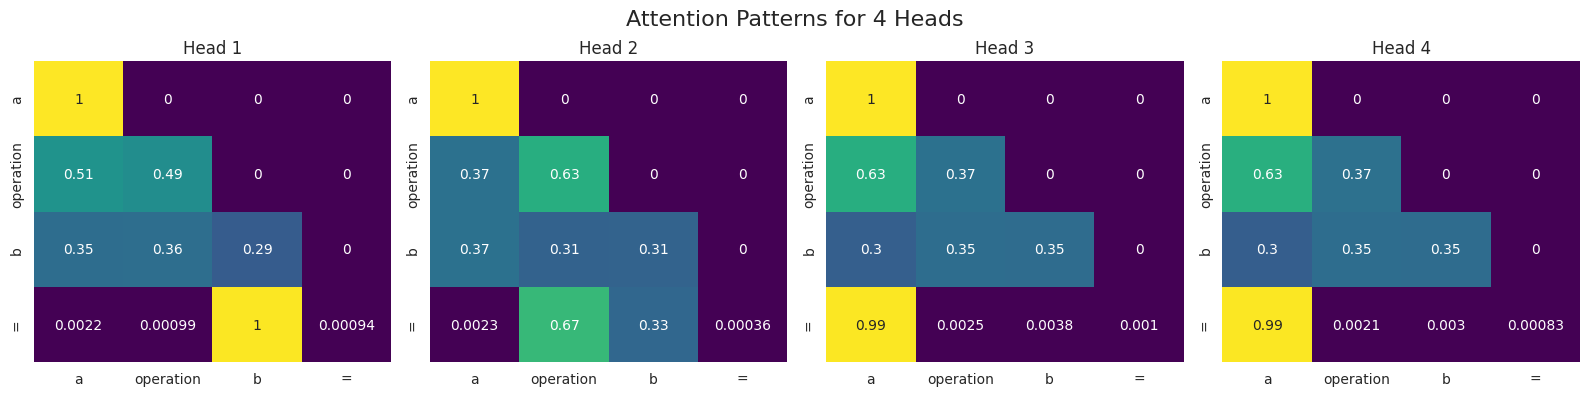

In [63]:
output_minus, cache_minus = model.run_with_cache(full_dataset[1::2])
av_attention = cache_minus["pattern", 0].mean(dim=0).detach().cpu()
labels = ['a', 'operation', 'b', '=']
# Create a figure to hold the 4 attention head plots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        av_attention[i],
        annot=True,  # Annotate each cell with its value
        xticklabels=labels,  # Set x-axis labels
        yticklabels=labels,  # Set y-axis labels
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'Head {i + 1}', fontsize=12)

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

all the following heatmaps are wrong

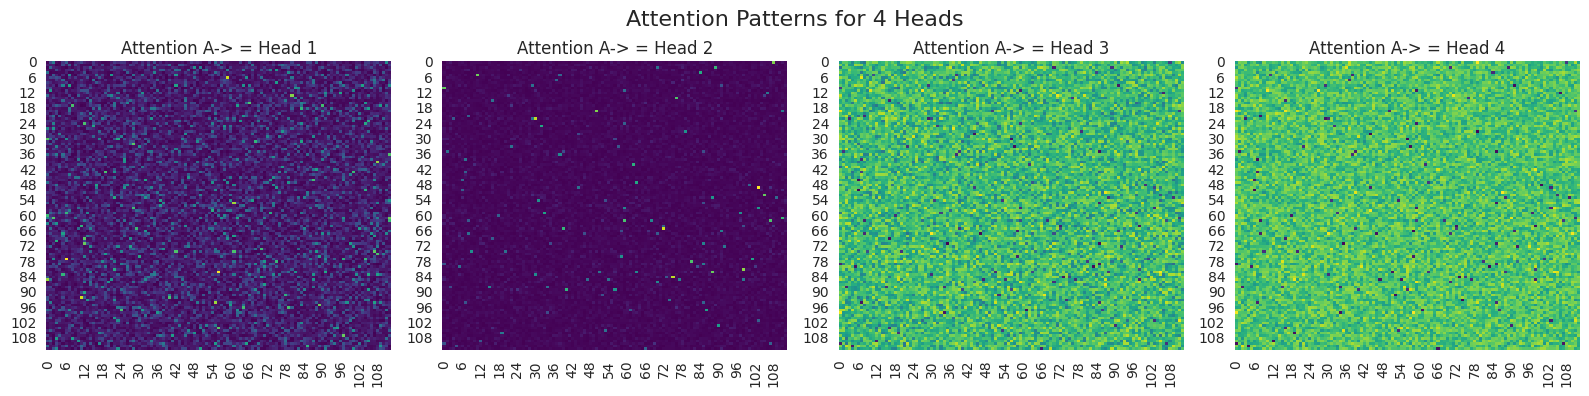

In [76]:
a_to_equals_attn_patterns = cache_plus["pattern", 0][:,:,-1,0].detach().cpu()
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        a_to_equals_attn_patterns[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'Attention A-> = Head {i + 1}', fontsize=12)
# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

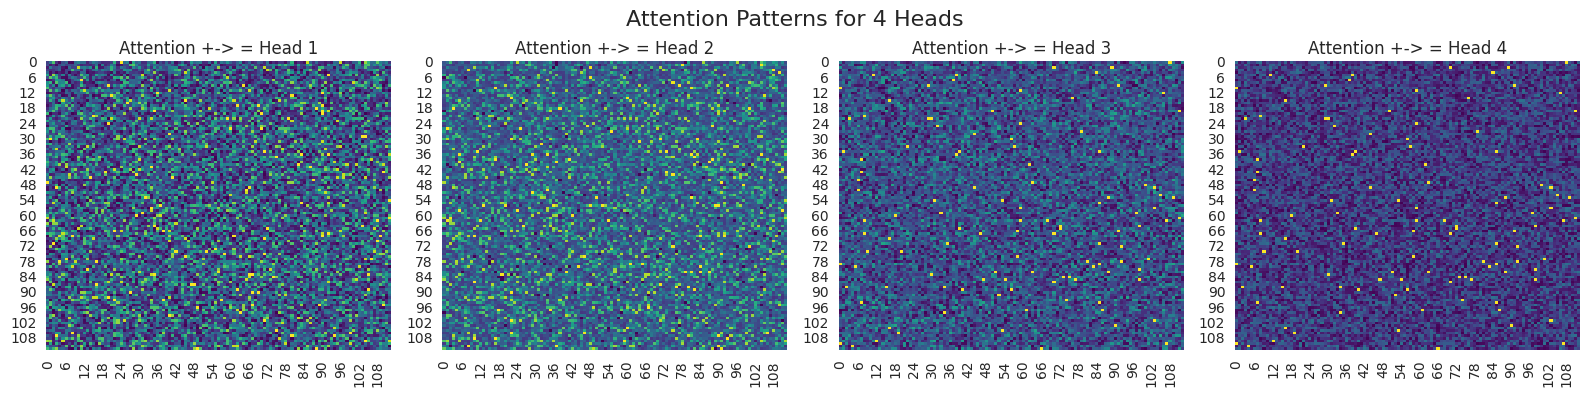

In [77]:
a_to_equals_attn_patterns = cache_plus["pattern", 0][:,:,-1,1].detach().cpu()
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        a_to_equals_attn_patterns[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'Attention +-> = Head {i + 1}', fontsize=12)
# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

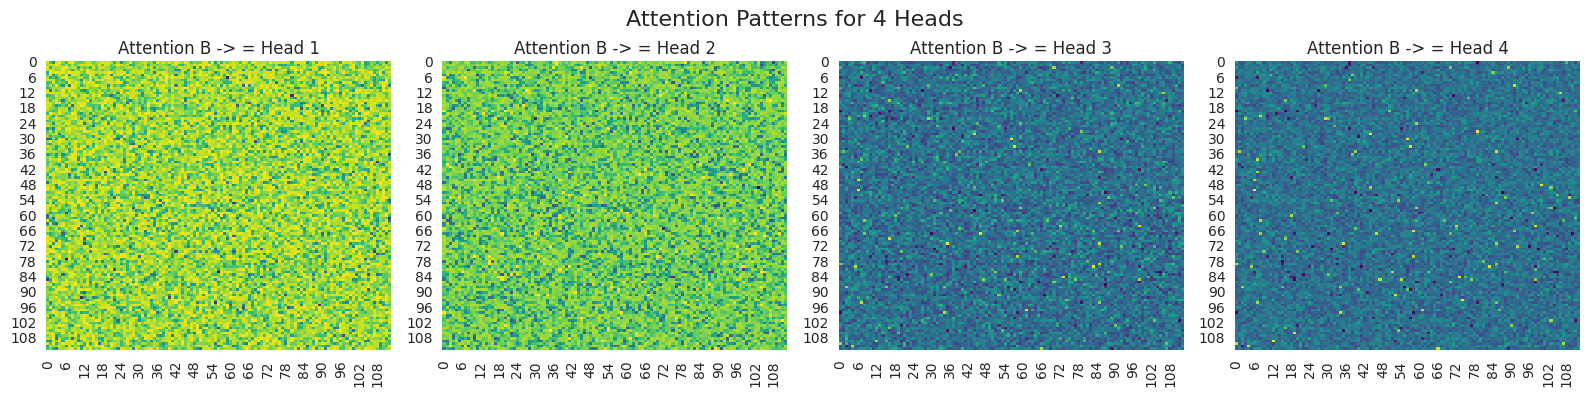

In [78]:
a_to_equals_attn_patterns = cache_plus["pattern", 0][:,:,-1,2].detach().cpu()
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        a_to_equals_attn_patterns[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'Attention B -> = Head {i + 1}', fontsize=12)
# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

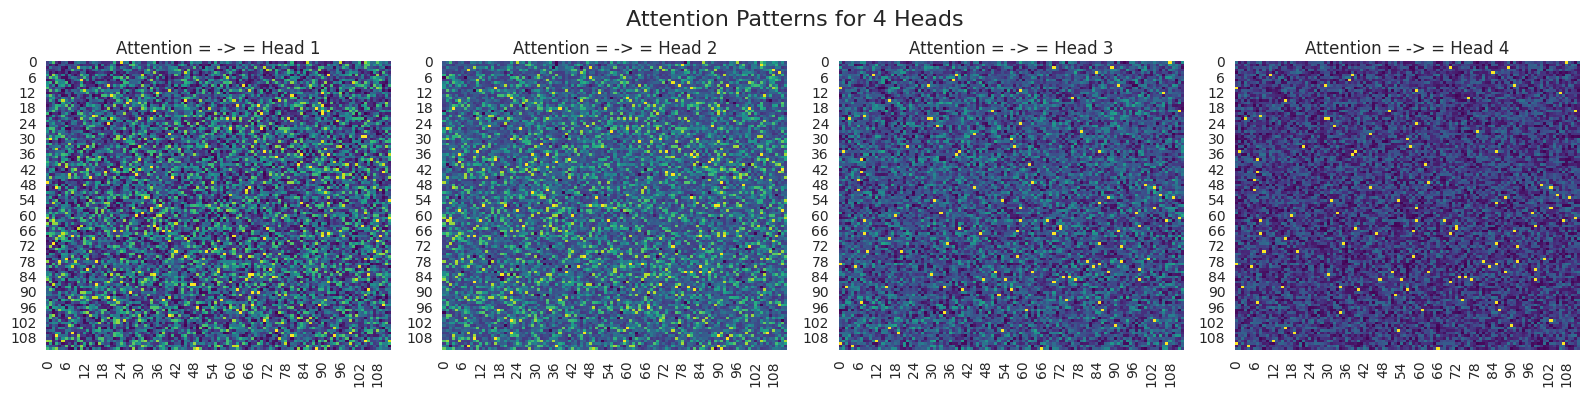

In [79]:
a_to_equals_attn_patterns = cache_plus["pattern", 0][:,:,-1,3].detach().cpu()
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        a_to_equals_attn_patterns[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'Attention = -> = Head {i + 1}', fontsize=12)
# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

We would expect the above to be periodic following the original paper so something is wrong here

/tmp/ipykernel_2317215/1043145692.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_results = torch.load('output.pt')


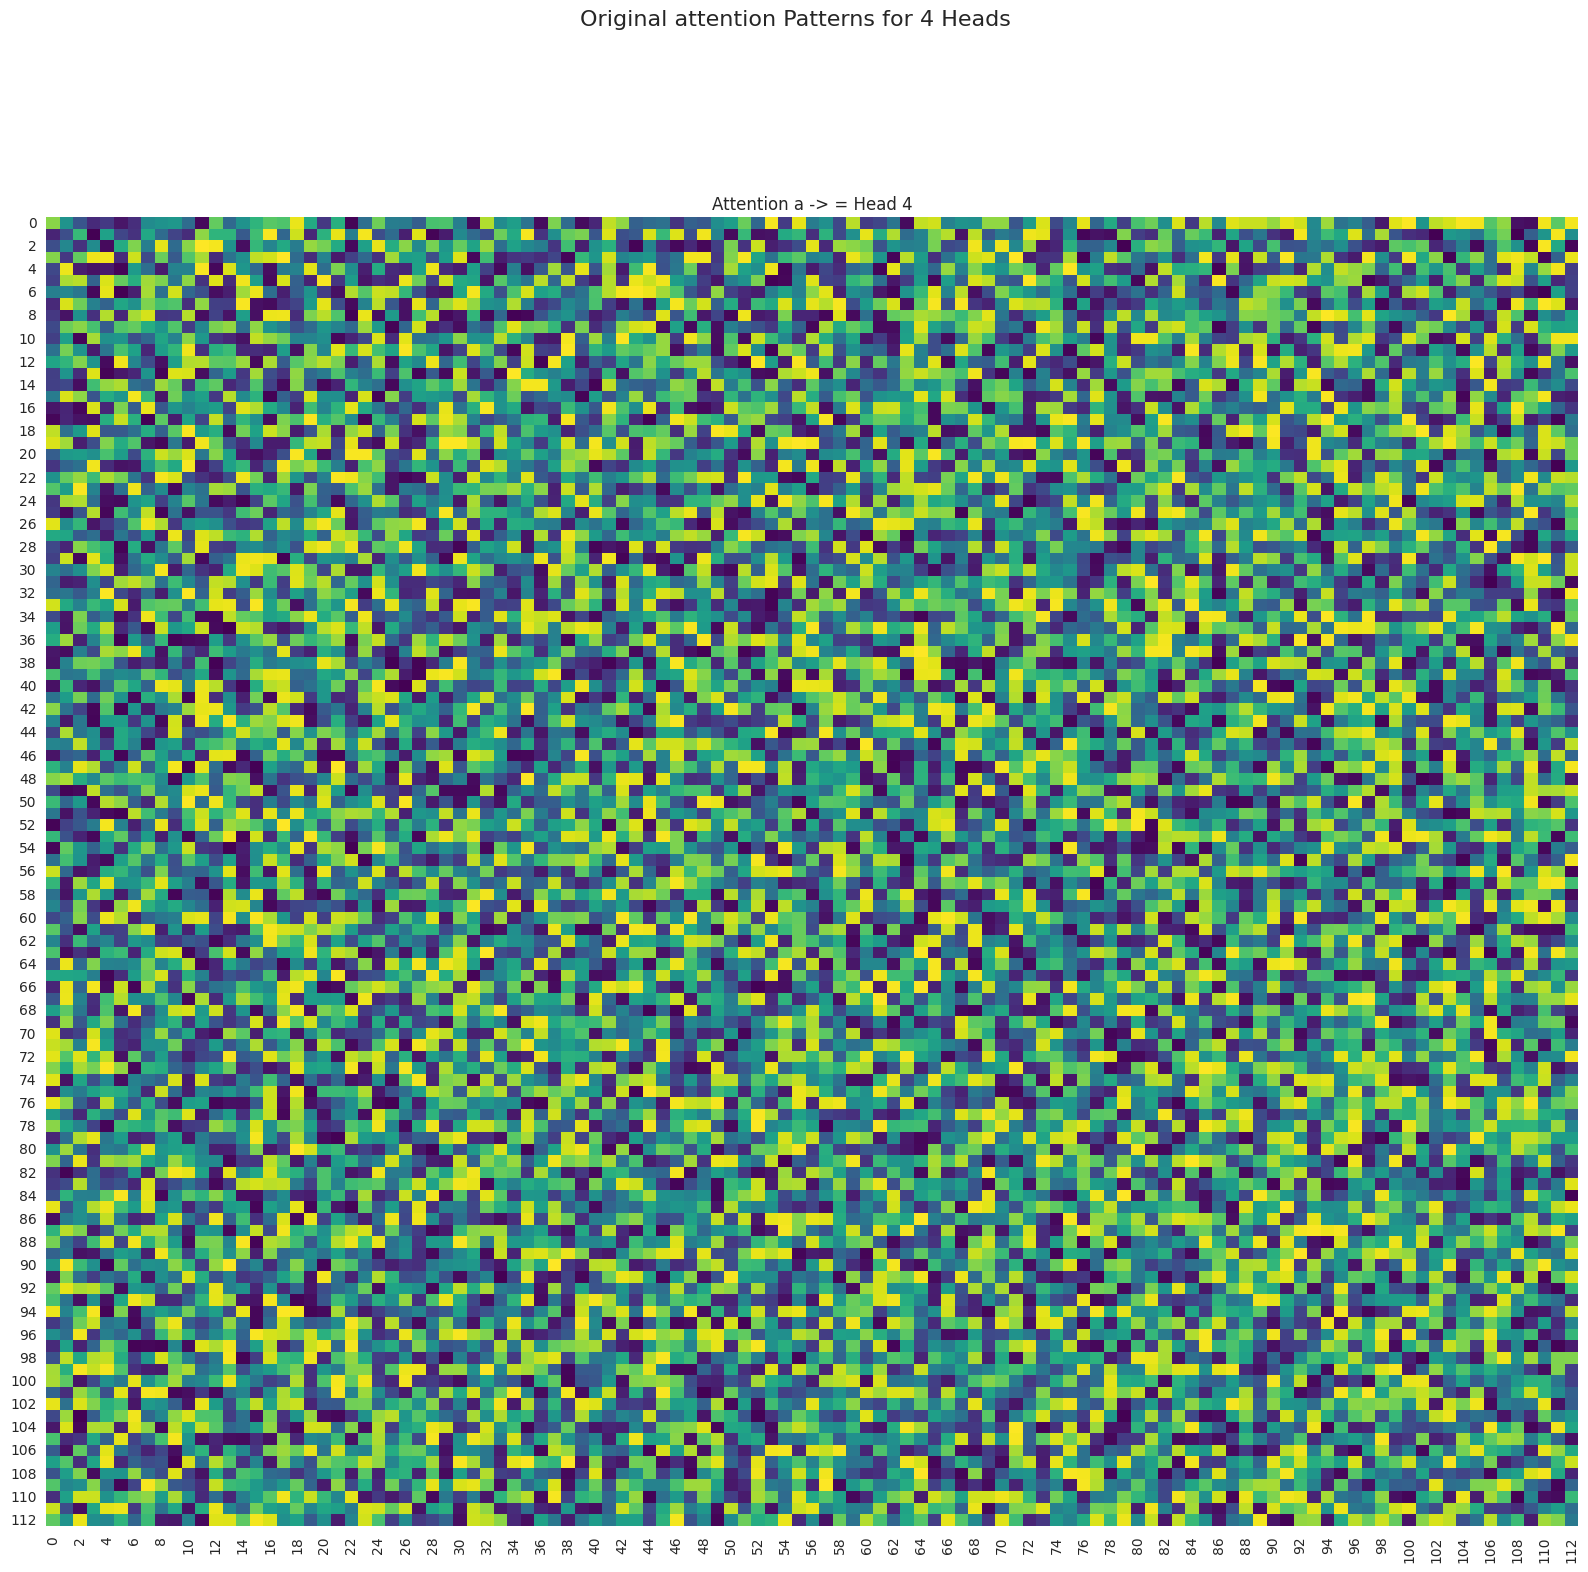

In [88]:
original_results = torch.load('output.pt')
original_model = HookedTransformer(original_results['config'])
original_model.load_state_dict(original_results['model'])
original_dataset = torch.concat([original_results['test_data'], original_results['train_data']], dim=0)
original_output, original_cache = original_model.run_with_cache(original_dataset)
a_to_equals_attn_patterns = original_cache["pattern", 0][:,0,-1,0].detach().cpu()
fig, axes = plt.subplots(1, 1, figsize=(16, 16))
fig.suptitle("Original attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern

sns.heatmap(
    a_to_equals_attn_patterns.reshape(113, 113),
    cmap="viridis",  # Use a color map
    cbar=False,  # Disable color bar to reduce clutter
    ax=axes  # Plot on the current axis
)
axes.set_title(f'Attention a -> = Head {i + 1}', fontsize=12)
# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

The datapoints are not ordered so the axis labels are wrong for all the above ^

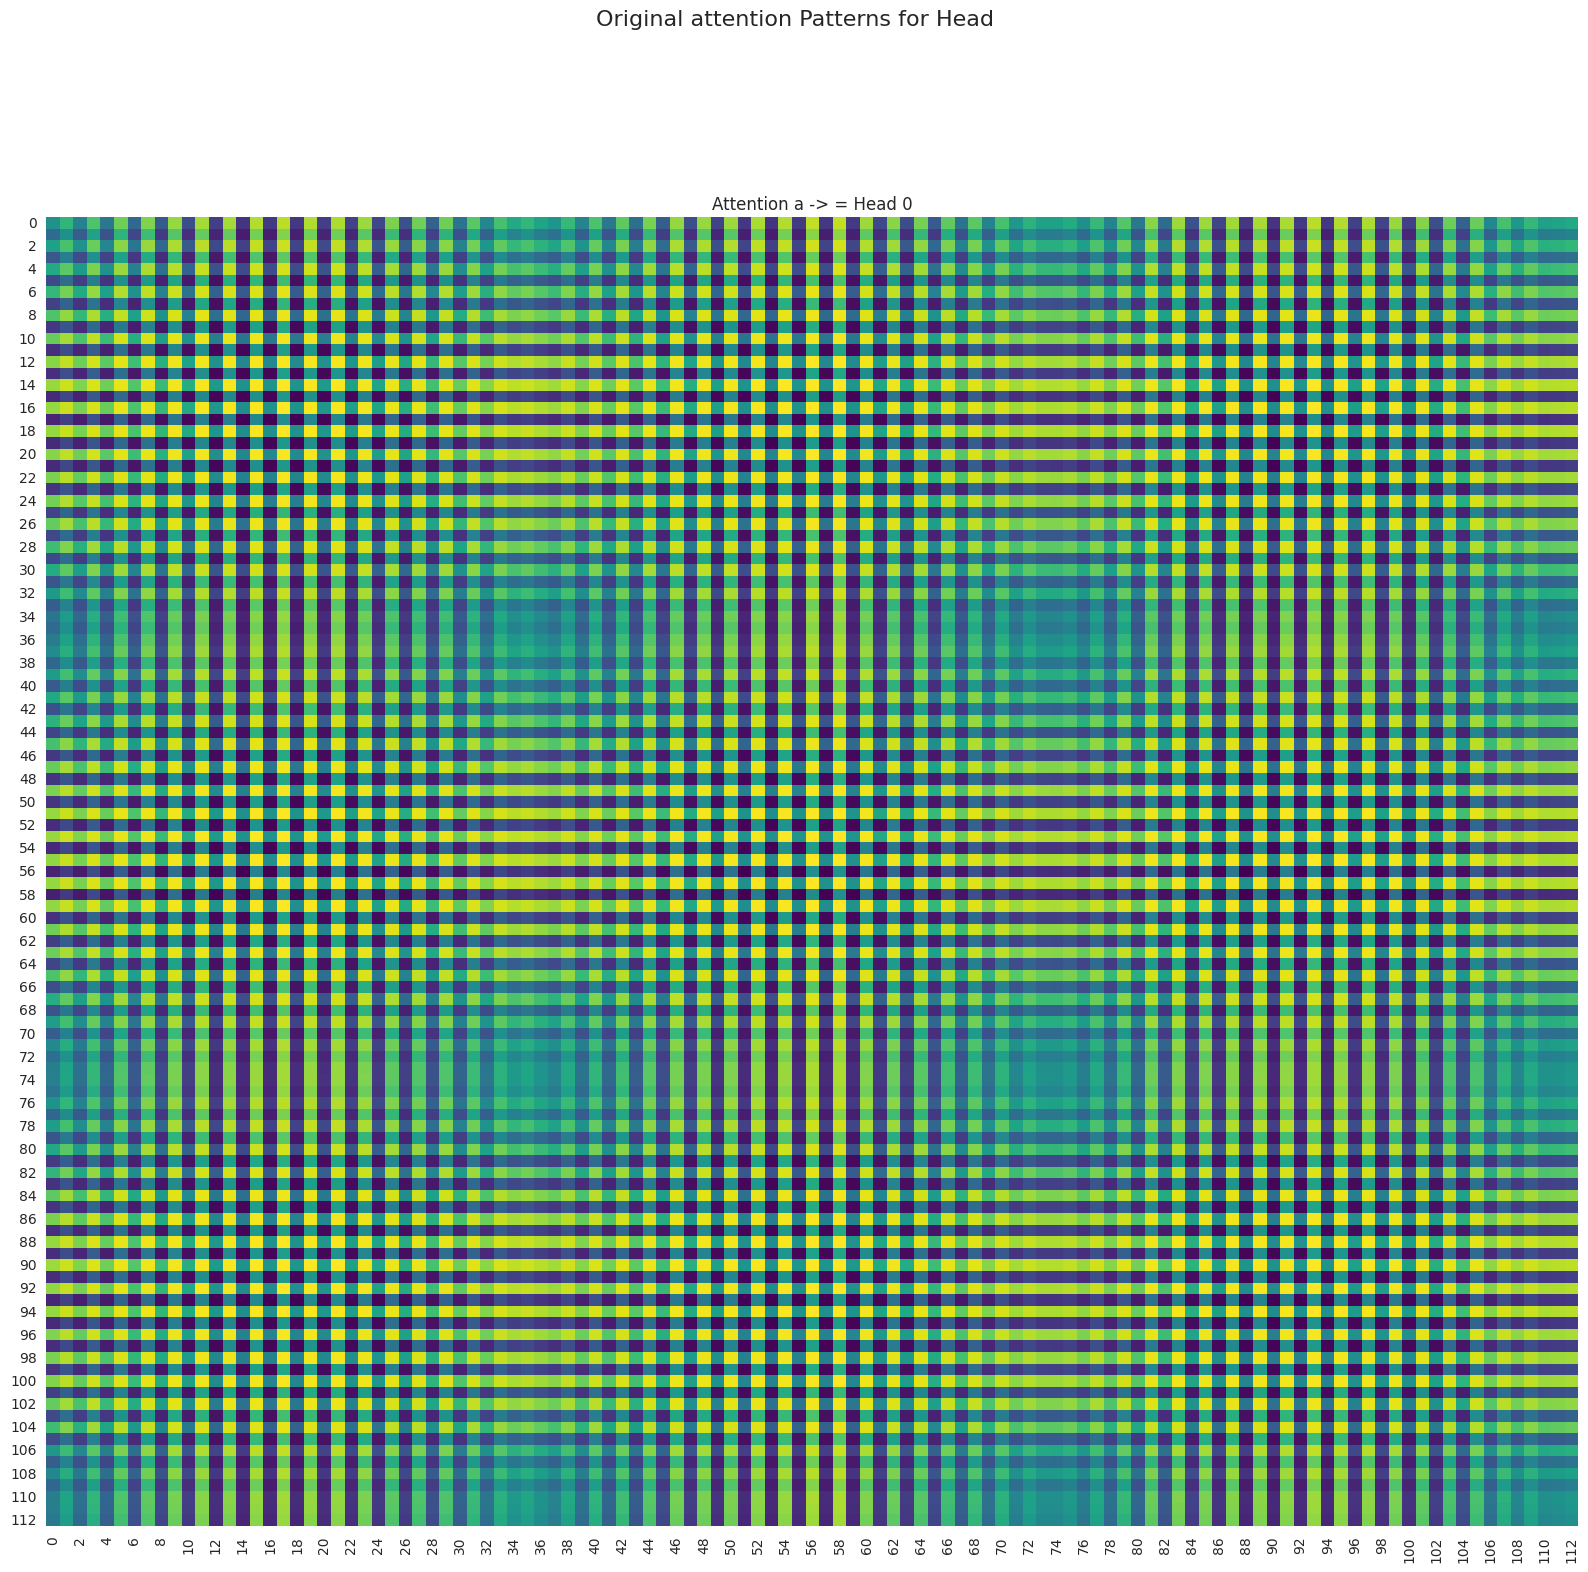

In [90]:
import einops
a_s = einops.repeat(torch.arange(113), "i -> (i j)", j=113)
b_s = einops.repeat(torch.arange(113), "j -> (i j)", i=113)
equals = einops.repeat(
    torch.tensor(113), " -> (i j)", i=113, j=113
)
original_dataset_correctly_ordered = torch.stack([a_s, b_s, equals], dim=1)
original_output, original_cache = original_model.run_with_cache(original_dataset_correctly_ordered)
a_to_equals_attn_patterns = original_cache["pattern", 0][:,0,-1,0].detach().cpu()
fig, axes = plt.subplots(1, 1, figsize=(16, 16))
fig.suptitle("Original attention Patterns for Head", fontsize=16)

# Loop through each head and plot its attention pattern

sns.heatmap(
    a_to_equals_attn_patterns.reshape(113, 113),
    cmap="viridis",  # Use a color map
    cbar=False,  # Disable color bar to reduce clutter
    ax=axes  # Plot on the current axis
)
axes.set_title(f'Attention a -> = Head {0}', fontsize=12)
# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

This is what we expect so need to go back and fix the rest of the above

# Staged Training

/tmp/ipykernel_2317215/1734121248.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load('output_plus_and_minus_staged.pt')


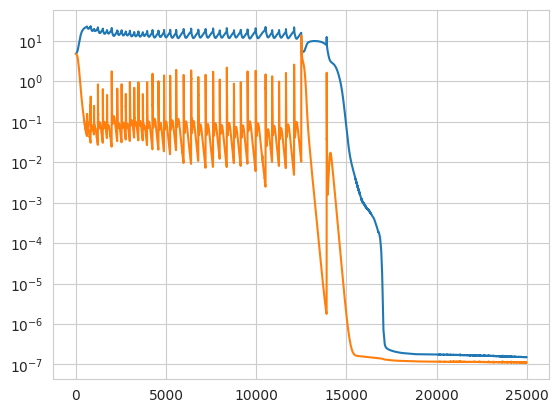

In [40]:
results = torch.load('output_plus_and_minus_staged.pt')
plt.plot(results['test_losses'])
plt.plot(results['train_losses'])
plt.yscale('log')



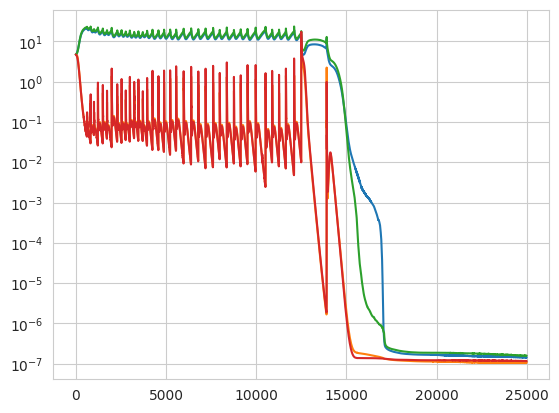

In [41]:
for operation in results['operations_losses']:
    plt.plot(operation['test_losses'])
    plt.plot(operation['train_losses'])
plt.yscale('log')